In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import time

In [2]:
print("--- Loading Data ---")
try: 
    df = pd.read_csv('archive/creditcard.csv')
    print("Data loaded successfully.")
    print("First 5 row of data")
    print(df.head())
    print(f"\nTontal number of transactions: {len(df)}")
    print("Class distribution (0: Not Fraud, 1: Fraud):")
    print(df['Class'].value_counts())
    print(f"Fraudulent transaction makes up {df['Class'].value_counts()[1] / len(df) * 100:.4f}% of the dataset.")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure the file path is correct or dowload 'archive/creditcard.csv' from Kaggle.")
    exit()
    
    
X = df.drop('Class', axis=1)
y = df['Class']

--- Loading Data ---
Data loaded successfully.
First 5 row of data
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278

In [3]:
print("\n--- Splitting data (Before Oversampling) ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print(f"Training set size: {X_train.shape} samples")
print(f"Test set size: {X_test.shape} samples")
print(f"Original training set class distribution:\n{y_train.value_counts()}")


--- Splitting data (Before Oversampling) ---
Training set size: (227845, 30) samples
Test set size: (56962, 30) samples
Original training set class distribution:
Class
0    227451
1       394
Name: count, dtype: int64


In [4]:
print("\n--- Applying SMOTE to Training Data ---")
sm = SMOTE(random_state=42)
start_time_smote = time.time()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)    
smote_time = time.time() - start_time_smote
print(f"SMOTE execution time: {smote_time:.4f} seconds")

print(f"Resampled training set size: {X_train_res.shape[0]} samples")
print(f"Resampled training set class distribution:\n{y_train_res.value_counts()}")


--- Applying SMOTE to Training Data ---


SMOTE execution time: 0.4512 seconds
Resampled training set size: 454902 samples
Resampled training set class distribution:
Class
0    227451
1    227451
Name: count, dtype: int64


In [5]:
#========== Feature Scaling ==============================
print("\n--- Feature Scaling ---")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_res),
    columns=X_train_res.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)
#==========================================================

print("\n--- Training Random Forest Classifier ---")

model = LogisticRegression(random_state=42, n_jobs=-1, class_weight='balanced', solver='lbfgs', max_iter=1000)


start_time_train = time.time()

#=================================================
model.fit(X_train_scaled, y_train_res)
#==================================================

train_time = time.time() - start_time_train
print(f"Random Forest model trained successfully in {train_time:.4f} seconds.")


--- Feature Scaling ---

--- Training Random Forest Classifier ---
Random Forest model trained successfully in 7.8739 seconds.


In [6]:
print("\n--- Evaluating Model ---")
start_time_predict = time.time()

#======================================
y_pred = model.predict(X_test_scaled) 
#======================================

predict_time = time.time() - start_time_predict
print(f"Prediction time: {predict_time:.4f} seconds")


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")    
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


--- Evaluating Model ---
Prediction time: 0.0030 seconds
Accuracy: 0.9899
Precision: 0.1348
Recall: 0.8980
F1-Score: 0.2344
ROC-AUC: 0.5112


In [7]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.23        98

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962



Confusion Matrix
[[56299   565]
 [   10    88]]


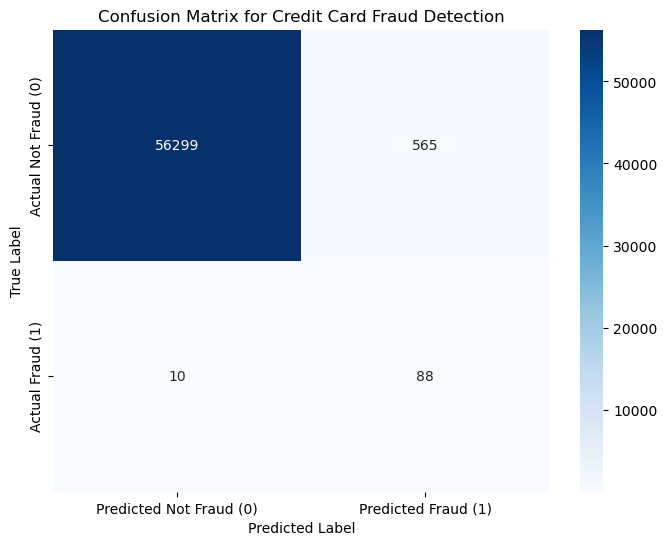


--- Analysis of Results (from Confusion Matrix) ---
True Negatives (Correctly identified Not Fraud): 56299
False Positives (Not Fraud -> Fraud): 565 (These are 'False Alarms')
False Negatives (Fraud -> Not Fraud): 10 (These are 'Missed Frauds' - very critical!)
True Positives (Correctly identified Fraud): 88


In [8]:
print(f"Confusion Matrix")
cm = confusion_matrix(y_test, y_pred)
print(cm)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Not Fraud (0)', 'Predicted Fraud (1)'],
            yticklabels=['Actual Not Fraud (0)', 'Actual Fraud (1)'])
plt.title('Confusion Matrix for Credit Card Fraud Detection')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Phân tích confusion matrix
print("\n--- Analysis of Results (from Confusion Matrix) ---")
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Correctly identified Not Fraud): {tn}")
print(f"False Positives (Not Fraud -> Fraud): {fp} (These are 'False Alarms')")
print(f"False Negatives (Fraud -> Not Fraud): {fn} (These are 'Missed Frauds' - very critical!)")
print(f"True Positives (Correctly identified Fraud): {tp}")